In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Session 20: Text Generation using RNN
<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

### Import TensorFlow and other libraries

In [2]:
# Lets import some libraries
import os
import time
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

2024-11-10 10:43:28.191845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731215608.204878    8334 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731215608.208730    8334 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 10:43:28.223544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def fn_verify_dir(_path):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder
        
        print(_path, ' exists') # advised the user
        
    else:
        
        os.makedirs(_path) # create the path
        
        print("Created folder : ", _path)

In [4]:
# Some basic parameters

inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models' # location to store models
subDir = 'text_gen' # location to store models

# verify if these path exist
fn_verify_dir(inpDir)
fn_verify_dir(outDir)
fn_verify_dir(modelDir)
fn_verify_dir(os.path.join(modelDir, subDir))

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

BATCH_SIZE = 64

EPOCHS = 75 # number of cycles to run

ALPHA = 0.1 # learning rate

../../../input  exists
../output  exists
../models  exists
../models/text_gen  exists


In [5]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Shakespeare dataset

In [6]:
filePath = os.path.join(inpDir, subDir, 'shakespeare.txt')
filePath

'../../../input/text_gen/shakespeare.txt'

In [7]:
text = open(filePath, 'rb').read().decode(encoding='utf-8')

len(text)

#tf.io.read_file(filePath).numpy()..decode(encoding='utf-8')

1115395

In [8]:
#text

In [9]:
print(text[:400])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


In [10]:
vocab = sorted(set(text))
len(vocab)

65

In [11]:
char2idx = {u:i for i, u in enumerate(vocab)} # 


idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

text_as_int.shape

(1115395,)

In [12]:
text_as_int

array([18, 47, 56, ...,  8,  0,  0])

In [13]:
type(text_as_int)

numpy.ndarray

In [14]:
text_as_int.shape

(1115395,)

In [15]:
idx2char[47]

np.str_('i')

In [16]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'B': 14,
 'C': 15,
 'D': 16,
 'E': 17,
 'F': 18,
 'G': 19,
 'H': 20,
 'I': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64}

In [17]:
dataset = tf.data.Dataset.from_tensor_slices([1.,2.,3.])

print (list(dataset.as_numpy_iterator()))

[np.float32(1.0), np.float32(2.0), np.float32(3.0)]


I0000 00:00:1731215609.964072    8334 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4175 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-11-10 10:43:29.988142: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
seq_length = 100

example_per_epoch = len(text) // (seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(10):
    
    print (i.numpy(), '|', idx2char[i.numpy()])

18 | F
47 | i
56 | r
57 | s
58 | t
1 |  
15 | C
47 | i
58 | t
47 | i


2024-11-10 10:43:30.014778: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(2):
    
    print (item)

tf.Tensor(
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1], shape=(101,), dtype=int64)
tf.Tensor(
[39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39 58 46 43 56  1
 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47 57 46 12  0  0
 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53 50 60 43 42  8
  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47 56 57 58  6  1
 63 53 59  1 49], shape=(101,), dtype=int64)


In [20]:
for item in sequences.take(2):
    
    print (repr( ''.join(idx2char[item.numpy()] ) ) )

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'


2024-11-10 10:43:30.041229: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
def split_input_target(chunk):
    
    input_text = chunk[:-1]
    
    target_text = chunk[1:]
    
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [22]:
for inp_ex, tar_ex in dataset.take (2):
    print (repr( ''.join(idx2char[inp_ex.numpy()] ) ))
    print (repr( ''.join(idx2char[tar_ex.numpy()] ) ))
    print ('*'*50, '\n')

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
************************************************** 

'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you '
're all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
************************************************** 



In [23]:
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [24]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_units = 1024


In [25]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    
    return tf.keras.models.Sequential([
            
        # Input layer specifies the expected shape
        tf.keras.layers.Input(shape=(None,), batch_size=batch_size),  # sequence length is None to allow variable length
        
        tf.keras.layers.Embedding(vocab_size, 
                                  embedding_dim
                                 ),

        # The model will take as input an integer matrix of size (batch,
        # input_length), and the largest integer (i.e. word index) in the input
        # should be no larger than vocab_size (vocabulary size).
        # Now model.output_shape is (None, embedding_dim, input_length), where `None` is the batch
        # dimension.
        
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True, 
                            stateful=True, 
                            recurrent_initializer='glorot_uniform'
                           ),
        tf.keras.layers.Dense(vocab_size)
    ])

In [26]:
# vocab_size, embedding_dim, rnn_units, batch_size
model = build_model(vocab_size= len(vocab), 
                    embedding_dim=embedding_dim, 
                    rnn_units = rnn_units,
                    batch_size= BATCH_SIZE)

In [27]:
for input_ex_batch, target_ex_batch in dataset.take(1):
    ex_batch_pred = model(input_ex_batch)

I0000 00:00:1731215611.549469    8419 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [28]:
ex_batch_pred.shape

TensorShape([64, 100, 65])

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, None, 256)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, None, 1024)       │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, None, 65)         │        66,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,021,569 (15.34 MB)

 Trainable params: 4,021,569 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
sampled_indices = tf.random.categorical(ex_batch_pred[0], num_samples=1)
print(sampled_indices.shape)
sampled_indices = tf.squeeze(sampled_indices, axis = -1).numpy()
print(sampled_indices.shape)

display(sampled_indices)
print (repr( ''.join(idx2char[sampled_indices] ) ))

(100, 1)
(100,)
'!EI$X\nVk $,?Pbh\nT.guNKzIGKj;DJoAwoYzFIouw\njpwdPM3uYeuNgYeOBxx?;,xSfH&DLoc$idxAqTSqcPNUGvv SgHRWl3d?h'


In [31]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [32]:
model.compile(optimizer = 'adam', loss=loss_fn)

In [33]:
chkPtPath = os.path.join(modelDir, subDir)

chkPtPrefix = os.path.join(chkPtPath, 'chkpt_{epoch}.keras')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=chkPtPrefix)

In [34]:
history = model.fit(dataset, epochs= EPOCHS,
                     callbacks=[checkpoint_callback], verbose = 2)

Epoch 1/75
172/172 - 7s - 39ms/step - loss: 2.5235
Epoch 2/75
172/172 - 6s - 34ms/step - loss: 1.8434
Epoch 3/75
172/172 - 6s - 34ms/step - loss: 1.6138
Epoch 4/75
172/172 - 6s - 35ms/step - loss: 1.4956
Epoch 5/75
172/172 - 6s - 35ms/step - loss: 1.4235
Epoch 6/75
172/172 - 6s - 34ms/step - loss: 1.3716
Epoch 7/75
172/172 - 6s - 35ms/step - loss: 1.3327
Epoch 8/75
172/172 - 6s - 35ms/step - loss: 1.2982
Epoch 9/75
172/172 - 6s - 35ms/step - loss: 1.2663
Epoch 10/75
172/172 - 6s - 35ms/step - loss: 1.2352
Epoch 11/75
172/172 - 6s - 35ms/step - loss: 1.2065
Epoch 12/75
172/172 - 6s - 35ms/step - loss: 1.1766
Epoch 13/75
172/172 - 6s - 35ms/step - loss: 1.1462
Epoch 14/75
172/172 - 6s - 35ms/step - loss: 1.1168
Epoch 15/75
172/172 - 6s - 35ms/step - loss: 1.0865
Epoch 16/75
172/172 - 6s - 35ms/step - loss: 1.0538
Epoch 17/75
172/172 - 6s - 35ms/step - loss: 1.0216
Epoch 18/75
172/172 - 6s - 35ms/step - loss: 0.9910
Epoch 19/75
172/172 - 6s - 35ms/step - loss: 0.9592
Epoch 20/75
172/172 -

In [49]:
hist_df = pd.DataFrame(history.history)
hist_df.loc[hist_df['loss'] == hist_df['loss'].min()]


,loss
41,0.653588


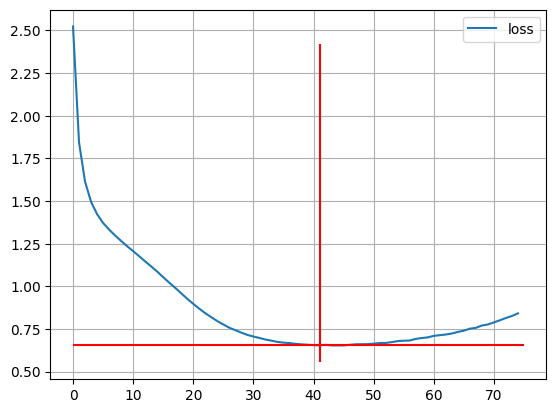

In [ ]:
ax = hist_df.plot()
ax.hlines(hist_df.loc[hist_df['loss'] == hist_df['loss'].min()].values, xmin = 0, xmax= EPOCHS, color = 'r')
ax.vlines(hist_df.loc[hist_df['loss'] == hist_df['loss'].min()].index, 
          ymin = hist_df.loc[hist_df['loss'] == hist_df['loss'].min()].values-0.1, 
          ymax= hist_df.loc[hist_df['loss'] == hist_df['loss'].max()].values-0.1, 
          color = 'r')
ax.grid()

In [35]:
!ls {chkPtPath}

chkpt_10.keras	chkpt_28.keras	chkpt_45.keras	     chkpt_61.keras
chkpt_11.keras	chkpt_29.keras	chkpt_46.keras	     chkpt_62.keras
chkpt_12.keras	chkpt_2.keras	chkpt_47.keras	     chkpt_63.keras
chkpt_13.keras	chkpt_30.keras	chkpt_48.keras	     chkpt_64.keras
chkpt_14.keras	chkpt_31.keras	chkpt_48_save.keras  chkpt_65.keras
chkpt_15.keras	chkpt_32.keras	chkpt_49.keras	     chkpt_66.keras
chkpt_16.keras	chkpt_33.keras	chkpt_4.keras	     chkpt_67.keras
chkpt_17.keras	chkpt_34.keras	chkpt_50.keras	     chkpt_68.keras
chkpt_18.keras	chkpt_35.keras	chkpt_51.keras	     chkpt_69.keras
chkpt_19.keras	chkpt_36.keras	chkpt_52.keras	     chkpt_6.keras
chkpt_1.keras	chkpt_37.keras	chkpt_53.keras	     chkpt_70.keras
chkpt_20.keras	chkpt_38.keras	chkpt_54.keras	     chkpt_71.keras
chkpt_21.keras	chkpt_39.keras	chkpt_55.keras	     chkpt_72.keras
chkpt_22.keras	chkpt_3.keras	chkpt_56.keras	     chkpt_73.keras
chkpt_23.keras	chkpt_40.keras	chkpt_57.keras	     chkpt_74.keras
chkpt_24.keras	chkpt_41.keras

In [56]:
hist_df.loc[hist_df['loss'] == hist_df['loss'].min()].index.to_numpy()[0]

np.int64(41)

In [57]:
model_num = hist_df.loc[hist_df['loss'] == hist_df['loss'].min()].index.to_numpy()[0]
checkpoint_path = os.path.join(chkPtPath, f'chkpt_{model_num}.keras')
# Step1: create model 
# vocab_size, embedding_dim, rnn_units, batch_size
model1 = build_model(vocab_size= len(vocab), 
                    embedding_dim=embedding_dim, 
                    rnn_units = rnn_units,
                    batch_size= 1)

# Step 2: Load only weights from the .keras file
model1.load_weights(checkpoint_path)

model1.build ( tf.TensorShape ( [1, None ] ) )

In [58]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, None, 256)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (1, None, 1024)        │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, None, 65)          │        66,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,021,569 (15.34 MB)

 Trainable params: 4,021,569 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
def generate_text(model, start_string):
    
    num_generate =  1000
    input_eval = [char2idx[s] for s in start_string] # [37, 48, 56 ]
    print (f'Input: {start_string} | {input_eval}\n')
    input_eval = tf.expand_dims(input_eval, 0) # tf.Tensor (1, 1, 5)
    text_generated = []
    
    #model.reset_states()
    
    for i in range(num_generate):
        
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predict_td = tf.random.categorical(predictions, 
                                            num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predict_td], 0)
        text_generated.append(idx2char[predict_td])
        
    return start_string+''.join(text_generated)

In [60]:
print (generate_text(model1, start_string=u'ROMEO:'))

Input: ROMEO: | [30, 27, 25, 17, 27, 10]

ROMEO:
At that sit in your let be?
Call me to-day? no think, I enpresshop,
Lest in this turnet but to his childness
Which he stands between two causes
I had so villany achick in the year,
Cof so quick and his fiem is still one suby.

LUCENTIO:
I'll have no truth to part the trumpets sound:
Be patient, those conquest of two have tame's
cift but mymbals: you
will empect a silk passages,
Which I do set me to, but what hath bound.
I had rather kiss it come, anon. We are not safe?

First Citizen:
See, sir.

POMPEY:
Sir, she comes Sount the Antiates;
This is the way the angry Mayor:
Ho, no more, no more than me?
If it be good unpleasion with shoese,
Whilst, who shall she knew to't,--
Of all thy suppects my brother Clarence!
And so in this be pack'd fourtentowers.

LUCENTIO:
What if shrieve your grace! I do request it;
It is strange and deceived; inform
This is the stemns of men, by your own in heaven,
Having some business better than our gentle-heart